In [25]:
# G Oldford Feb 19 2022

# visualize monte carlo results from ecosim Monte Carlo
# uses ggplot2
#
# https://erdavenport.github.io/R-ecology-lesson/05-visualization-ggplot2.html

In [1]:
library(tidyverse)
library(matrixStats)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.4
v tibble  2.1.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'matrixStats'

The following object is masked from 'package:dplyr':

    count



In [58]:
# No biomass found in the auto written MC run out files, so saving from the plot direct from MC plugin
# The B's are relative to initialization year!
path_MC_sc1 = "C://Users//Greig//Sync//PSF//EwE//Georgia Strait 2021//UTL_model//6_MRM_SealTKWJuveSlmn//Results//"
file_MC_sc1 = "MRM_SealsTKWJuveSalm_Feb172022_NOTKWforce_graph_MCs_500trials.csv"
n_MC_runs_1 = 500 # sets cols that correspond to seal B

path_MC_sc2 = "C://Users//Greig//Sync//PSF//EwE//Georgia Strait 2021//UTL_model//6_MRM_SealTKWJuveSlmn//Results//SealWCT_Feb172022_midB-WCT//mc_Scenario 2b- WCT Forcing - Mid B//"
file_MC_sc2 = "BiomassDirectSaveMC_test_2022-02-19_500runs.csv"
n_MC_runs_2 = 500 

relB_base = 0.134 # base yr seal B hard coded - careful
path_TS = "C://Users//Greig//Sync//PSF//EwE//Georgia Strait 2021//UTL_model//6_MRM_SealTKWJuveSlmn//"
file_TS = "SealWCT_B_timeseries_Scen2b_rev20220217v3_MidB.csv"

# ==== read MC results file ====
header_lines = 1

header_lines = 1
results_df_sc1 <- read.csv(paste(path_MC_sc1, file_MC_sc1,sep=""), skip = header_lines)
# rename col and get seals B only
results_trim_TKWForcemid_sc1 = results_df_sc1 %>% rename(year = Data) %>% 
               select(c("year",starts_with("X2..Seals")))  %>%
               mutate(year_int = round(year,0)) %>%
               filter(year_int < 2022) #deals with single row w/ erroroneous large year at end of TS data
# head(results_trim_TKWForcemid_sc1)

results_df_sc2 <- read.csv(paste(path_MC_sc2, file_MC_sc2,sep=""), skip = header_lines)
# rename col and get seals B only
results_trim_TKWForcemid_sc2 = results_df_sc2 %>% rename(year = Data) %>% 
               select(c("year",starts_with("X2..Seals"))) %>%
               mutate(year_int = round(year,0)) %>%
               filter(year_int < 2022) #deals with single row w/ erroroneous large year at end of TS data
    
# head(results_trim_TKWForcemid_sc2)

# ==== read TS reference file ====
header_lines = 3
sealobs_df <- read.csv(paste(path, file,sep=""), skip = header_lines)
#relB_base = sealobs_df$BiomassAbs[1]
# convert to relative B
sealobs_df$SealsObsRelB = sealobs_df$BiomassAbs / relB_base
seals_obs_relB = sealobs_df %>% rename(year = Type) %>% 
               select(c("year","SealsObsRelB")) %>%
               mutate(source = "surveys")

# pivot tables to long, for scatter plotting
sc1_df = results_trim_TKWForcemid_sc1 %>% select(-year) %>% 
         pivot_longer(!year_int, names_to = "Mc_run_sc", values_to = "RelB") %>% 
         mutate(scenario = "No TKW")
sc2_df = results_trim_TKWForcemid_sc2 %>% select(-year) %>% 
         pivot_longer(!year_int, names_to = "Mc_run_sc", values_to = "RelB") %>% 
         mutate(scenario = "TKW")

# combine
sc_df = bind_rows(sc1_df,sc2_df)


# # rename 'data' col to Year
# results_trim = results_df %>% rename(year = Data) %>% 
#                select(c(0:n_MC_runs))
# head(results_trim)

In [ ]:
# to do - eliminate scenarios where seals go extinct. 
# likely this is due to issues with total catch (forcing) time series. 
# EwE doesn't allow for F forcing.

Warning message:
"Removed 1680 rows containing missing values (geom_point)."

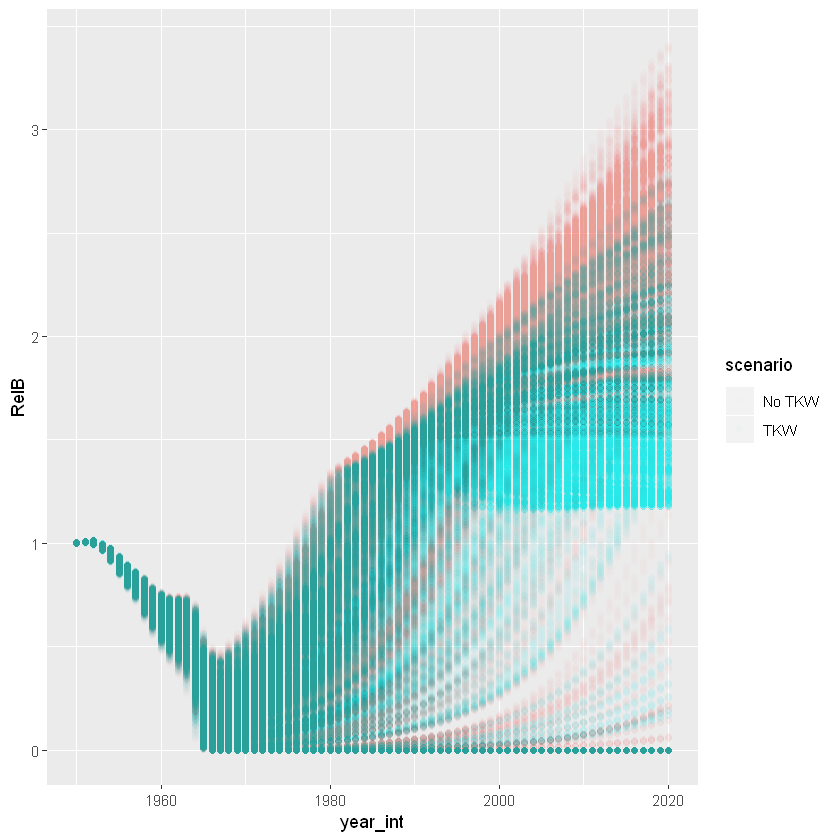

In [59]:
ggplot(data = sc_df, aes(x = year_int, y = RelB)) +
  geom_point(alpha = 0.01, aes(color=scenario))

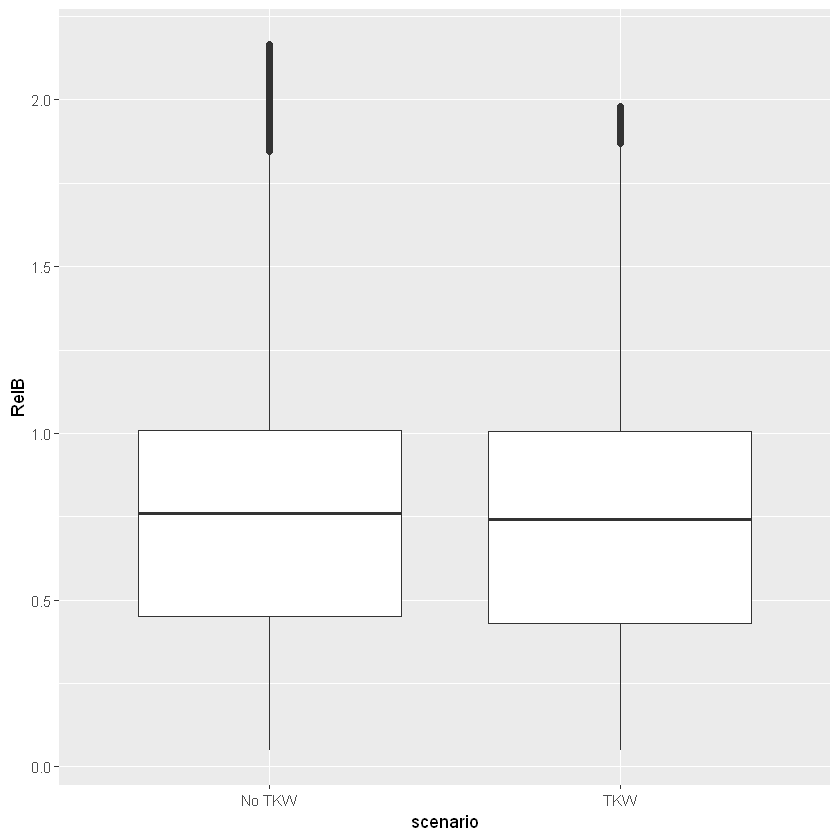

In [61]:
# visualize, scenario 1 vs scenario 2, after year 2000 when seals plateau
sc_2000fwd_df = sc_df %>% filter(year_int < 2000) %>% 
                filter(RelB > 0.05)
ggplot(data = sc_2000fwd_df, aes(x = scenario, y = RelB)) +
    geom_boxplot()

In [ ]:
# OLD CODE BELOW

In [29]:


# for geom_ribbon plots get upper and lower bound 
columns <- grep("X2..Seals", colnames(results_trim_TKWForcemid))

results_trim_TKWmid = results_trim_TKWForcemid %>% 
 mutate(Mean= rowMeans(.[columns],,na.rm = TRUE), 
         logMean = rowMeans(log(.[columns]),na.rm = TRUE),
         stdev=rowSds(as.matrix(.[columns]),na.rm = TRUE), 
         stdev_log=rowSds(as.matrix(log(.[columns])),na.rm = TRUE)) %>%
# 95% confidence interv https://www.mathsisfun.com/data/confidence-interval.html
  mutate(upper_B = Mean + (1.96 * stdev / sqrt(n_MC_runs)), 
        lower_B = Mean - (1.96 * stdev / sqrt(n_MC_runs))) %>%
  mutate(year_int = round(year,0)) %>%
  filter(year_int < 2022) %>% #deals with weird super-large year at end of TS data
  select(c("year_int","Mean", "stdev", "lower_B","upper_B")) %>%
  mutate(source = "EwE") %>%
  rename(year = year_int) %>%
  # 12 vals per year - average the stats within years
  group_by(year) %>% dplyr::summarize(mean_yr = mean(Mean, na.rm=TRUE), 
                                      mean_std = mean(stdev, na.rm=TRUE), 
                                      mean_lwrB = mean(lower_B, na.rm=TRUE),
                                      mean_uppB = mean(upper_B, na.rm=TRUE))

results_trim_TKWmid


`summarise()` ungrouping output (override with `.groups` argument)


year,mean_yr,mean_std,mean_lwrB,mean_uppB
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1950,1.0011379,0.000188222,1.0011226,1.0011531
1951,1.0047715,0.001089587,1.0046834,1.0048597
1952,1.0060953,0.002522664,1.0058913,1.0062994
1953,0.9825929,0.004267533,0.9822477,0.9829382
1954,0.9531233,0.007233238,0.9525381,0.9537084
1955,0.8992448,0.012726529,0.8982152,0.9002743
1956,0.8501407,0.019202986,0.8485872,0.8516941
1957,0.8103546,0.026018534,0.8082497,0.8124594
1958,0.7547954,0.035199713,0.7519478,0.7576430


In [ ]:
model_obs_binding = bind_rows(results_trim2,seals_obs_relB)

(model_obs_binding)

In [ ]:
ggplot(data = roughrundata_df, aes(x = year, y = seals_sc1)) +
    geom_line() +
    geom_ribbon(aes(ymin=seals_sc1_lo, ymax=seals_sc1_up),alpha = 0.1, fill = "blue") +
    geom_line(aes(y=seals_sc2b)) +
    geom_ribbon(aes(y=seals_sc2b, ymin=seals_sc2b_lo, ymax=seals_sc2b_up),alpha = 0.1, fill = "green") +
    geom_point(data = seals_obs_relB_norecent, aes(y=SealsObsRelB_mt, x=year),alpha = 0.8, color = "black") + 
    ylab("Seal Biomass Density (mt km-2)") 

In [24]:
# # for geom_ribbon plots get upper and lower bound 
# columns <- c(2:n_MC_runs)

# Old stuff
# results_trim2 = results_trim_TKWForcemid %>% 
#   mutate(Mean= rowMeans(.[columns]), 
#          logMean = rowMeans(log(.[columns])),
#          stdev=rowSds(as.matrix(.[columns])), 
#          stdev_log=rowSds(as.matrix(log(.[columns])))) %>%
#   mutate(upper_B = Mean + (1.96 * stdev / sqrt(n_MC_runs)), # 95% confidence interv https://www.mathsisfun.com/data/confidence-interval.html
#         lower_B = Mean - (1.96 * stdev / sqrt(n_MC_runs))) %>%
#   mutate(year_int = round(year,0)) %>%
#   filter(year_int < 2022) %>% #deals with weird super-large year at end of TS data
#   select(c("year_int","Mean", "stdev", "lower_B","upper_B")) %>%
#   mutate(source = "EwE") %>%
#   rename(year = year_int) %>%
#   # at this point there are 12 vals per year but these appear to jump every year
#   # below will average the stats across each year
#   group_by(year) %>% dplyr::summarize(mean_yr = mean(Mean, na.rm=TRUE), 
#                                       mean_std = mean(stdev, na.rm=TRUE), 
#                                       mean_lwrB = mean(lower_B, na.rm=TRUE),
#                                       mean_uppB = mean(upper_B, na.rm=TRUE))


  #mutate(upper_B = exp(upper_logB), 
  #       lower_B = exp(lower_logB)) 



# pivot wide to long
#results_piv = results_trim2 %>% pivot_longer(
#   cols = starts_with("X2"),
#   names_to = "Seals",
#   names_prefix = "",
#   values_to = "B",
#   values_drop_na = TRUE
# )

# head(results_trim2)
# I can't find Biomass in the auto written MC run out files, so I'm saving from the plot in the MC plugin
#path = "C://Users//Greig//Sync//PSF//EwE//Georgia Strait 2021//UTL_model//6_MRM_SealTKWJuveSlmn//Results//SealWCT_Feb172022_midB-WCT//mc_Scenario 3c- MonteCarlo TKWForce Mid//"
#file = "BiomassPlotSave_Scen3b_TKWForce_min.csv"
#file = "BiomassPlotSave_Scen3c_TKWForce_mid_500runs.csv"
#file = "BiomassDirectSaveMC_test_2022-02-19.csv"

#starts_with(results_trim_TKWForcemid,"X2..Seals")
#grep("X2..Seals", colnames(results_trim_TKWForcemid))
#results_trim_TKWForcemid

# # for geom_ribbon plots get upper and lower bound 
# columns <- grep("X2..Seals", colnames(results_trim_TKWForcemid))

# results_trim_TKWmid = results_trim_TKWForcemid %>% 
#  mutate(Mean= rowMeans(.[columns],,na.rm = TRUE), 
#          logMean = rowMeans(log(.[columns]),na.rm = TRUE),
#          stdev=rowSds(as.matrix(.[columns]),na.rm = TRUE), 
#          stdev_log=rowSds(as.matrix(log(.[columns])),na.rm = TRUE)) %>%
#   mutate(upper_B = Mean + (1.96 * stdev / sqrt(n_MC_runs)), # 95% confidence interv https://www.mathsisfun.com/data/confidence-interval.html
#         lower_B = Mean - (1.96 * stdev / sqrt(n_MC_runs))) %>%
#   mutate(year_int = round(year,0)) %>%
#   filter(year_int < 2022) %>% #deals with weird super-large year at end of TS data
#   select(c("year_int","Mean", "stdev", "lower_B","upper_B")) %>%
#   mutate(source = "EwE") %>%
#   rename(year = year_int) %>%
#   # at this point there are 12 vals per year but these appear to jump every year
#   # below will average the stats across each year
#   group_by(year) %>% dplyr::summarize(mean_yr = mean(Mean, na.rm=TRUE), 
#                                       mean_std = mean(stdev, na.rm=TRUE), 
#                                       mean_lwrB = mean(lower_B, na.rm=TRUE),
#                                       mean_uppB = mean(upper_B, na.rm=TRUE))


  #mutate(upper_B = exp(upper_logB), 
  #       lower_B = exp(lower_logB)) 



# pivot wide to long
#results_piv = results_trim2 %>% pivot_longer(
#   cols = starts_with("X2"),
#   names_to = "Seals",
#   names_prefix = "",
#   values_to = "B",
#   values_drop_na = TRUE
# )

# tail(results_trim_TKWmid)

# read seal time series data
# convert from abs to rel to match MC out
# path = "C://Users//Greig//Sync//PSF//EwE//Georgia Strait 2021//UTL_model//6_MRM_SealTKWJuveSlmn//"
#file = "SealTKW_timeseries_Scen1_NoTKWForcing.csv"
# file = "SealWCT_B_timeseries_Scen2b_rev20220217v3_MidB.csv"


# header_lines = 3
# sealobs_df <- read.csv(paste(path, file,sep=""), skip = header_lines)
# #relB_base = sealobs_df$BiomassAbs[1]
# relB_base = 0.134
# sealobs_df$SealsObsRelB = sealobs_df$BiomassAbs / relB_base
# seals_obs_relB = sealobs_df %>% rename(year = Type) %>% 
#                select(c("year","SealsObsRelB")) %>%
#                mutate(source = "surveys")
# #sealobs_df
# (seals_obs_relB)
# merge two tables
# model_obs_binding = bind_rows(results_trim2,seals_obs_relB)

# (model_obs_binding)

In [49]:
SealsObsRelB_1970on = seals_obs_relB %>% filter(year > 1969)

Warning message:
"Ignoring unknown aesthetics: y"

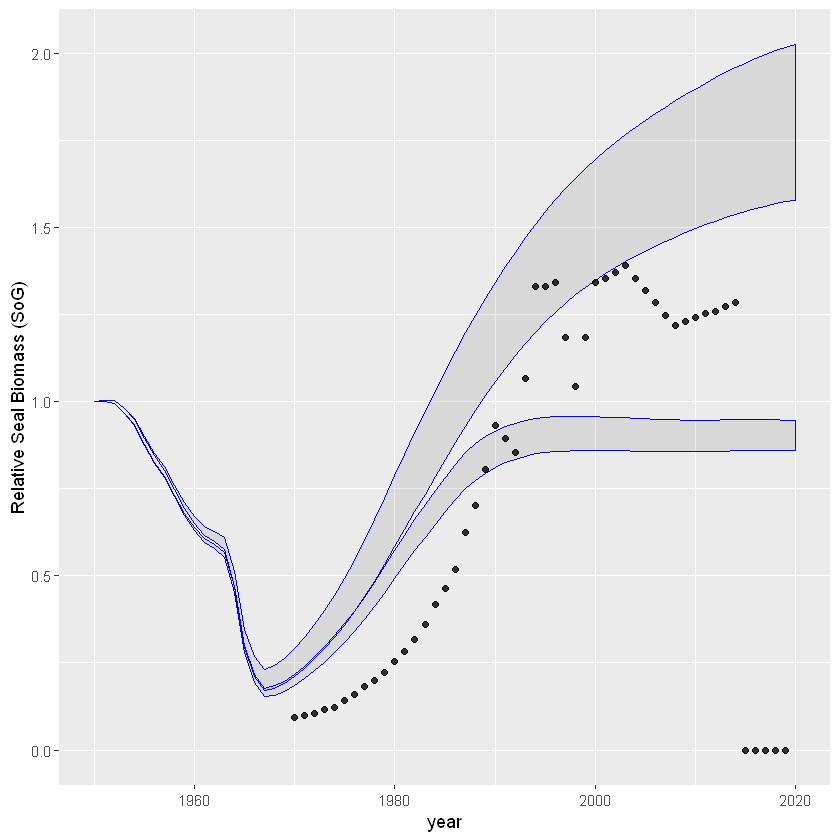

In [54]:
ggplot(data = results_trim2, aes(x = year, y = mean_yr)) +
    geom_ribbon(aes(ymin=mean_lwrB, ymax=mean_uppB),alpha = 0.1, color = "blue") +
    geom_ribbon(data = results_trim_TKWmid, aes(y=mean_yr, ymin=mean_lwrB, ymax=mean_uppB),alpha = 0.1, color = "blue") +
    geom_point(data = SealsObsRelB_1970on, aes(y=SealsObsRelB, x=year),alpha = 0.8, color = "black") + 
    ylab("Relative Seal Biomass (SoG)")

In [56]:
# temporary
# read seal time series data
# convert from abs to rel to match MC out
path = "C://Users//Greig//Sync//PSF//EwE//Georgia Strait 2021//UTL_model//6_MRM_SealTKWJuveSlmn//results//"
file = "biomass_annual_justresultsnoMC_scen1scen2b.csv"
header_lines = 0
roughrundata_df <- read.csv(paste(path, file,sep=""), skip = header_lines)


head(roughrundata_df)



year,seals_sc1,seals_sc1_up,seals_sc1_lo,seals_sc2b,seals_sc2b_up,seals_sc2b_lo
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1950,0.1698849,0.2208504,0.1359079,0.1698851,0.2208506,0.1359081
1951,0.1697782,0.2207117,0.1358226,0.1697793,0.2207131,0.1358234
1952,0.1666590,0.2166567,0.1333272,0.1666638,0.2166629,0.1333310
1953,0.1612633,0.2096423,0.1290106,0.1612942,0.2096825,0.1290354
1954,0.1530211,0.1989274,0.1224169,0.1531146,0.1990490,0.1224917
1955,0.1429197,0.1857956,0.1143358,0.1431347,0.1860751,0.1145078


Warning message:
"Ignoring unknown aesthetics: y"

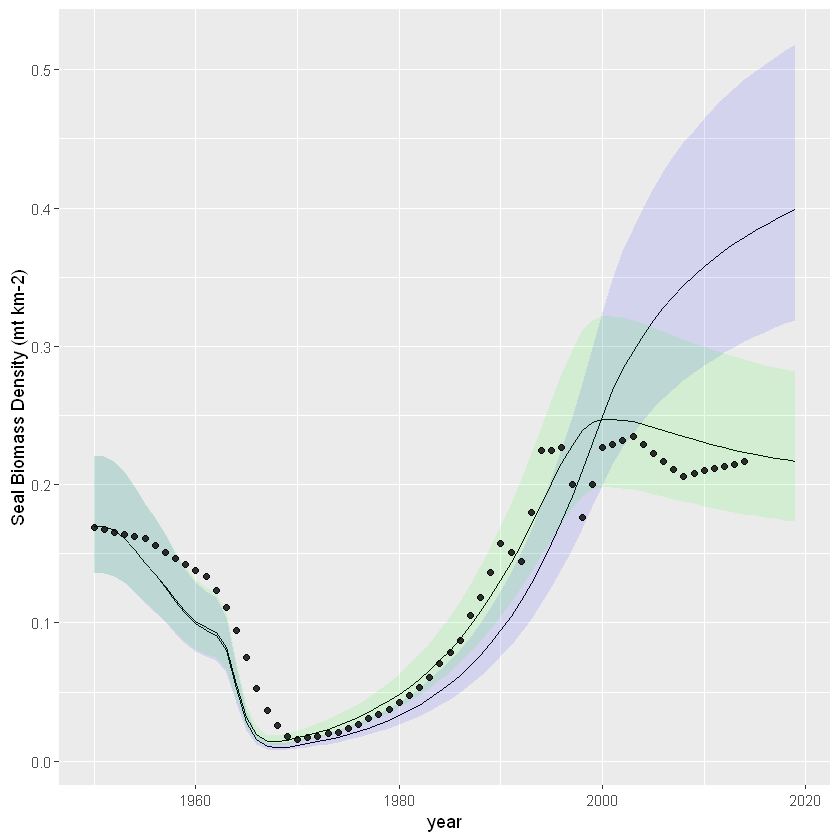

In [78]:
ggplot(data = roughrundata_df, aes(x = year, y = seals_sc1)) +
    geom_line() +
    geom_ribbon(aes(ymin=seals_sc1_lo, ymax=seals_sc1_up),alpha = 0.1, fill = "blue") +
    geom_line(aes(y=seals_sc2b)) +
    geom_ribbon(aes(y=seals_sc2b, ymin=seals_sc2b_lo, ymax=seals_sc2b_up),alpha = 0.1, fill = "green") +
    geom_point(data = seals_obs_relB_norecent, aes(y=SealsObsRelB_mt, x=year),alpha = 0.8, color = "black") + 
    ylab("Seal Biomass Density (mt km-2)") 

In [60]:
seals_obs_relB$SealsObsRelB_mt = seals_obs_relB$SealsObsRelB * 0.169

In [77]:
seals_obs_relB_norecent = seals_obs_relB %>% filter(seals_obs_relB < 2015)